In [1]:
# STEP 1: Install the libraries (if not existing already) [already installed for me]

# !pip install yfinance pandas numpy matplotlib scikit-learn

In [2]:
# STEP 2: Importing the libraries

import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2025-01-01', end='2025-10-01')

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

/tmp/ipython-input-37984150.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2025-01-01', end='2025-10-01')
[*********************100%***********************]  1 of 1 completed

Dataset shape: (186, 5)


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


Missing values in dataset:
 Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


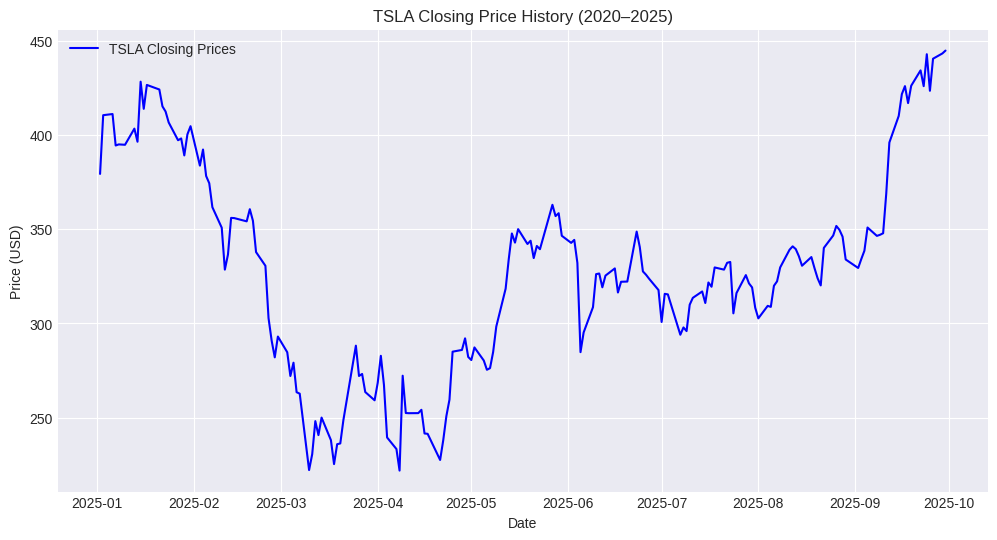

In [ ]:
# STEP 4: Data Cleaning and Visualization
# (Lecture 3: Data preprocessing before training)

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction (Lecture 8: Sequential data)
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time
plt.figure(figsize=(12,6))
plt.plot(data.index, close_prices, label=f"{ticker} Closing Prices", color='blue')
plt.title(f"{ticker} Closing Price History (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [ ]:
# STEP 5: Data Scaling and Sequence Creation
# (Lecture 3: Data normalization for stable training)
# (Lecture 8: Preparing sequential input for RNN (LSTM))

# Normalize closing prices to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Define how many past days to use for predicting the next day
time_step = 30  # Can be changed to 60 later for more memory
X, y = [], []

# Create sequences (input: last 30 days, output: next day)
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i, 0])
    y.append(scaled_data[i, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape input to 3D (samples, time steps, features)
# Required format for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (156, 30, 1)
y shape: (156,)


In [ ]:
# STEP 6: Split the dataset into training and testing sets
# (Lecture 3: Model evaluation requires separate train/test data)

# Define training data size (80% of total samples)
training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (124, 30, 1) (124,)
Testing set size: (32, 30, 1) (32,)


In [ ]:
# STEP 8.5: Add Sentiment Feature using News Headlines
# (Extension idea from team – combine market data + news sentiment)
# This feature uses daily sentiment of news articles for the company (Lecture 6: Multi-Feature DL)

!pip install nltk requests --quiet

import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', quiet=True)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Sentiment Feature using EODHD Financial News API
# (Replaces earlier NewsAPI integration for better financial coverage)

def get_company_news(ticker, api_token="demo"):
    url = f"https://eodhd.com/api/news?s={ticker}.US&offset=0&limit=50&api_token={api_token}&fmt=json"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()
        if isinstance(data, dict):
            print("⚠️ Unexpected response format, using empty list.")
            return pd.DataFrame(columns=["date", "title"])
        return pd.DataFrame([{"date": item["date"][:10], "title": item["title"]} for item in data])
    except Exception as e:
        print("Could not fetch news:", e)
        return pd.DataFrame(columns=["date", "title"])

# Fetch headlines for the company
print("\nFetching news data...")
news_df = get_company_news("TSLA")  # you can change to 'MSFT', 'AAPL', etc.
print("Fetched news headlines:", len(news_df))

# Perform sentiment analysis
if not news_df.empty:
    news_df['sentiment'] = news_df['title'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    news_df['date'] = pd.to_datetime(news_df['date'])
    daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
else:
    print("No news data found, using neutral sentiment (0).")
    daily_sentiment = pd.DataFrame(columns=['date', 'sentiment'])

# Merge sentiment into stock data
data_multi = data.copy()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]
data_multi.reset_index(inplace=True)

data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)

data_multi['sentiment'] = data_multi['sentiment'].fillna(0)

print("\nSentiment feature added successfully! Example:")
print(data_multi[['Close', 'sentiment']].head())

# Sentiment Summary
print("\nSentiment Summary:")
print(f"Average sentiment score: {news_df['sentiment'].mean():.4f}")
print(f"Positive headlines: {(news_df['sentiment'] > 0).mean() * 100:.1f}%")
print(f"Negative headlines: {(news_df['sentiment'] < 0).mean() * 100:.1f}%")
print(f"Neutral headlines:  {(news_df['sentiment'] == 0).mean() * 100:.1f}%")


Fetching news data...
Fetched news headlines: 50

Sentiment feature added successfully! Example:
        Close  sentiment
0  379.279999        0.0
1  410.440002        0.0
2  411.049988        0.0
3  394.359985        0.0
4  394.940002        0.0

Sentiment Summary:
Average sentiment score: -0.0998
Positive headlines: 16.0%
Negative headlines: 38.0%
Neutral headlines:  46.0%


In [ ]:
# VERIFICATION: See a few of the fetched headlines and their individual sentiment scores
sample = news_df[['title', 'sentiment']].head(10)
print(sample)


                                               title  sentiment
0  Tesla is stepping into its most critical era, ...    -0.3804
1  Dow Jones Futures Fall After Tesla, Nvidia, Pa...     0.0000
2  Burry’s Depreciation Gripe Shines Spotlight on...     0.4404
3  This Week In Electric Vehicles - Riding The Wa...     0.0000
4  These Stocks Are Moving the Most Today: Tesla,...     0.0000
5  Trending tickers: Tesla, Nvidia, Strategy, Sof...     0.0000
6  Risk Aversion Sinks Market High Flyers as Fed ...    -0.5106
7  U.S. Futures, Global Markets Fall as Fed Inter...     0.1779
8  FTSE 100 LIVE: London slides and UK gilts sell...     0.0000
9  Prediction: This Stock Will Outperform Nvidia ...     0.0000


In [ ]:
# Before Step 7 and 8 because this is a multi-feature
# STEP 9: Add Multi-Feature Inputs for More Realistic Predictions
# (Lecture 6 – Multi-Feature Deep Learning)
# (Lecture 3 – Feature Scaling & Normalization)

# Start fresh from price data but merge sentiment from earlier
data_multi = data.copy().reset_index()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Merge sentiment data (daily_sentiment) into the price data
data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)


# Create additional features
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# Drop any rows with missing values due to rolling calculations
data_multi.dropna(inplace=True)

# Flatten column names if needed (yfinance often adds multi-level columns)
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Select features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"Features used: {features} \n")

# Prepare the feature matrix
multi_data = data_multi[features].values

# Scale all features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

# Create time-series sequences
time_step = 30  # using 30-day windows
X, y = [], []
for i in range(time_step, len(scaled_multi)):
    X.append(scaled_multi[i-time_step:i])  # past 30 days of all features
    y.append(scaled_multi[i, 0])           # target = next day's Close price

X, y = np.array(X), np.array(y)
print("New input shape (X):", X.shape)
print("New target shape (y):", y.shape)
print()

# Split into training & testing sets again
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Features used: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment'] 

New input shape (X): (1407, 30, 9)
New target shape (y): (1407,)

Training set: (1125, 30, 9) (1125,)
Testing set: (282, 30, 9) (282,)


In [ ]:
# STEP 7: Build and Train the LSTM Model
# (Lecture 6 – Multi-Layer Deep Networks)
# (Lecture 8 – Recurrent Neural Networks with multiple features)

# Define an enhanced LSTM architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Layer 1
    Dropout(0.2),
    LSTM(64, return_sequences=False),  # Layer 2
    Dropout(0.2),
    Dense(32, activation='relu'),      # Dense layer for deeper feature mapping
    Dense(1)                           # Output layer (next-day price)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Display model summary
model.summary()


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0803 - val_loss: 0.0267
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 0.0145
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0039 - val_loss: 0.0117
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035 - val_loss: 0.0157
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 0.0101
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0021 - val_loss: 0.0072
Epoch 9/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 10/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 11/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 12/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,245 (633.77 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,164 (422.52 KB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Sample of Actual vs Predicted Prices with Dates:

          Date  Actual Price  Predicted Price
272 2025-10-17    439.309998       391.983287
273 2025-10-20    447.429993       393.626237
274 2025-10-21    442.600006       397.851066
275 2025-10-22    438.970001       400.750468
276 2025-10-23    448.980011       401.716102
277 2025-10-24    433.720001       402.260818
278 2025-10-27    452.420013       400.804910
279 2025-10-28    460.549988       403.914825
280 2025-10-29    461.510010       408.928298
281 2025-10-30    440.100006       413.397816


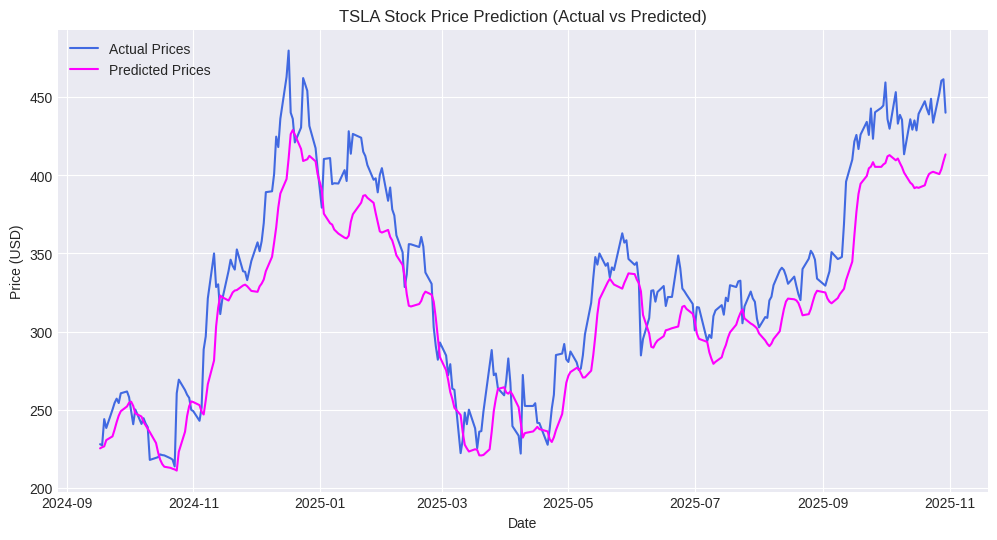


Mean Squared Error (MSE): 790.9251053025536


In [ ]:
# STEP 8: Model Prediction and Visualization
# (Lecture 3 – Model Evaluation & Visualization)
# (Lecture 8 – Forecasting with Recurrent Networks)

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
pred_dates = data.index[-len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


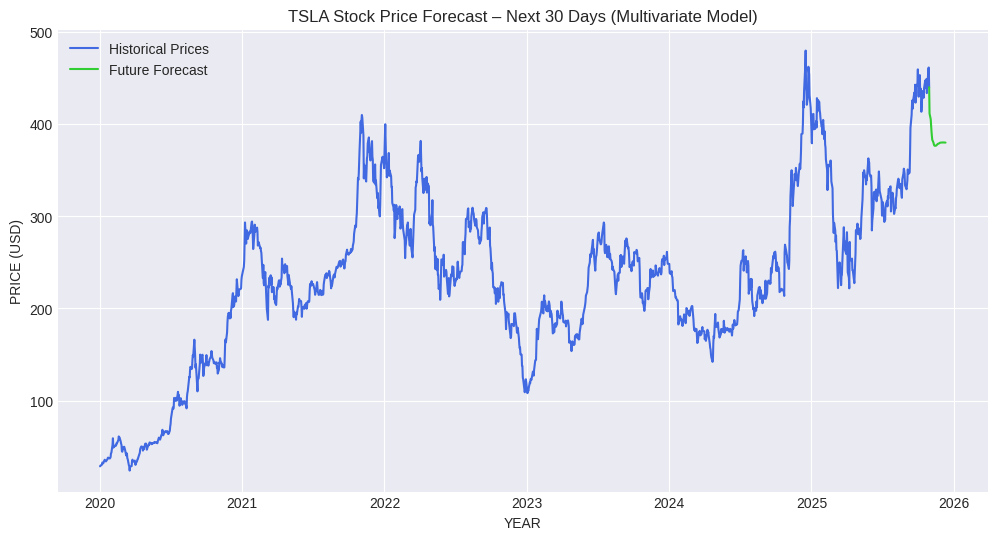

In [ ]:
# STEP 10 (Multivariate): Future Forecasting Beyond the Dataset
# (Lecture 8 – Forecasting using RNN sequence memory)

future_days = 30  # For longer forecast

# Take the last 30 days of all 9 features (correcting from 8)
last_30_days = scaled_multi[-30:, :]
future_input = last_30_days.reshape(1, 30, last_30_days.shape[1]).copy() # Use shape[1] to dynamically get the number of features

future_predictions = []

for _ in range(future_days):
    # Predict only the next day's 'Close' (first feature)
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions.append(next_close_scaled)

    # Create the next input window:
    # start with previous sequence, drop first row
    next_sequence = future_input[:, 1:, :].copy()

    # For the new day:
    # keep other feature values same as last day
    new_day = future_input[:, -1, :].copy()
    new_day[0][0] = next_close_scaled  # replace Close value with predicted one

    # Append new day to the end
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, last_30_days.shape[1]), axis=1) # Use shape[1]
    future_input = next_sequence

# Convert only the Close predictions back to original scale
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
future_predictions_unscaled = np.array(future_predictions) * (close_max - close_min) + close_min

# Create future business-day dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Combine into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

print("\nPredicted Future Prices:\n")
print(future_df)

# To make sure there is no gap between historical and forecast lines
last_actual_price = data['Close'].iloc[-1]
last_actual_date = data.index[-1]

# Insert the last known point at the start of the future forecast
future_df = pd.concat([
    pd.DataFrame({'Date': [last_actual_date], 'Predicted Price': [last_actual_price]}),
    future_df
], ignore_index=True)


# Plot historical + future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'],
         label="Future Forecast", color='limegreen')
plt.title(f"{ticker} Stock Price Forecast – Next {future_days} Days (Multivariate Model)")
plt.xlabel("YEAR")
plt.ylabel("PRICE (USD)")
plt.legend()
plt.show()

/tmp/ipython-input-577724428.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(future_df['Predicted Price'].iloc[0])
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)



--- Investment Advice ---
Predicted change over next 31 days: -13.65%

Model Suggests: 
 DOWNTREND DETECTED – Avoid investing right now or consider SELLING. 

R² Score: 0.8274343811130194

Report generated on: 2025-11-14 06:54 AM 



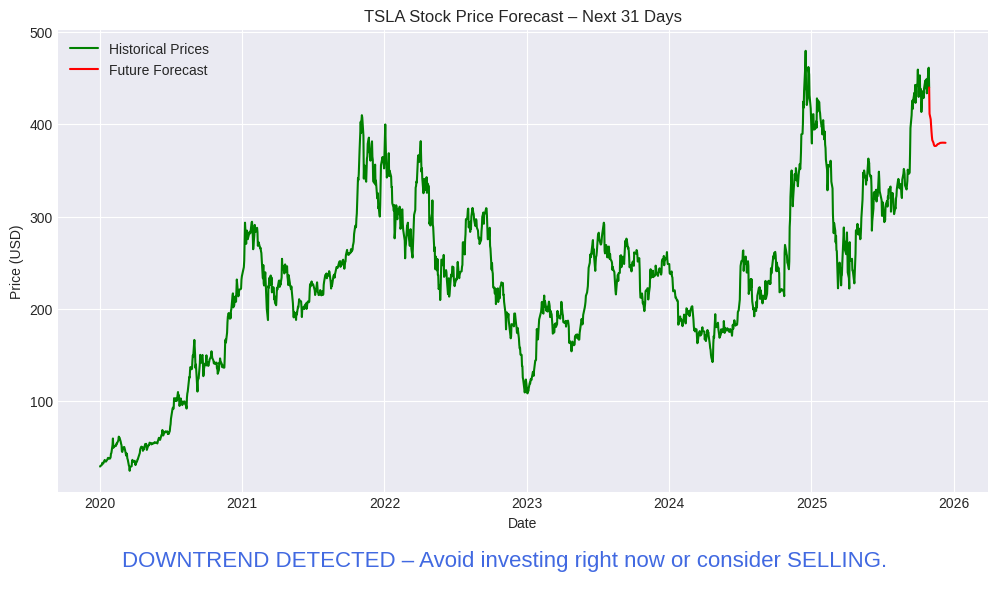

<Figure size 640x480 with 0 Axes>

In [ ]:
# STEP 11: Investment Advice Based on Predicted Trend
# (Lecture 3 – Model Evaluation & Decision Making)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)


r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

In [ ]:
# STEP 12: Model Performance Summary
# 12.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 12.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("✅ Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("✅ Good model fit. Model captures major trends well.")
else:
    print("⚠️ Model could be improved with more epochs, features, or tuning.")



        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      790.925105
Mean Absolute Error (MAE):     23.1653 USD
R² Score (Model Fit):          0.8274

Number of layers in this single model: 6
Total trainable parameters: 54,081

✅ Good model fit. Model captures major trends well.
